# Семинар 4. Тестрование гипотез:

Краткий синопсис:
1. Разбор статьи *"How Many Random Seeds? Statistical Power Analysis in Deep Reinforcement Learning Experiments"*...
2. ...и применение выводов авторов статей на примере задачи сравнения двух моделей для предсказания рака груди (https://archive.ics.uci.edu/ml/datasets/Breast+Cancer)
3. Оценка ошибки второго рода оценки $H_0$ - что две модели имеют одну и ту же предсказательную способность

### 1. Генерация тестовых выборок с точностями (prediction accuracy) для предсказания рака груди

https://arxiv.org/abs/1806.08295

The features from the data set describe characteristics of the cell nuclei and are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. As described in [UCI Machine Learning Repository][1], the attribute informations are:

1. ID number
2. Diagnosis (M = malignant, B = benign)

3 - 32  Ten real-valued features are computed for each cell nucleus:

* a) radius (mean of distances from center to points on the perimeter)
* b) texture (standard deviation of gray-scale values)
* c) perimeter
* d) area
* e) smoothness (local variation in radius lengths)
* f) compactness (perimeter^2 / area - 1.0)
* g) concavity (severity of concave portions of the contour)
* h) concave points (number of concave portions of the contour)
* i) symmetry
* j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.


  [1]: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

In [46]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [47]:
df = pd.read_csv('data.csv');

print("\n \t The data frame has {0[0]} rows and {0[1]} columns. \n".format(df.shape))
df.drop(df.columns[[-1, 0]], axis=1, inplace=True)
df.head()


 	 The data frame has 569 rows and 33 columns. 



,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [49]:
#  count how many diagnosis are malignant (M) and how many are benign (B)
diagnosis_all = list(df.shape)[0]
diagnosis_categories = list(df['diagnosis'].value_counts())

print("\n \t The data has {} diagnosis, {} malignant and {} benign.".format(diagnosis_all, 
                                                                            diagnosis_categories[0], 
                                                                            diagnosis_categories[1]))


 	 The data has 569 diagnosis, 357 malignant and 212 benign.


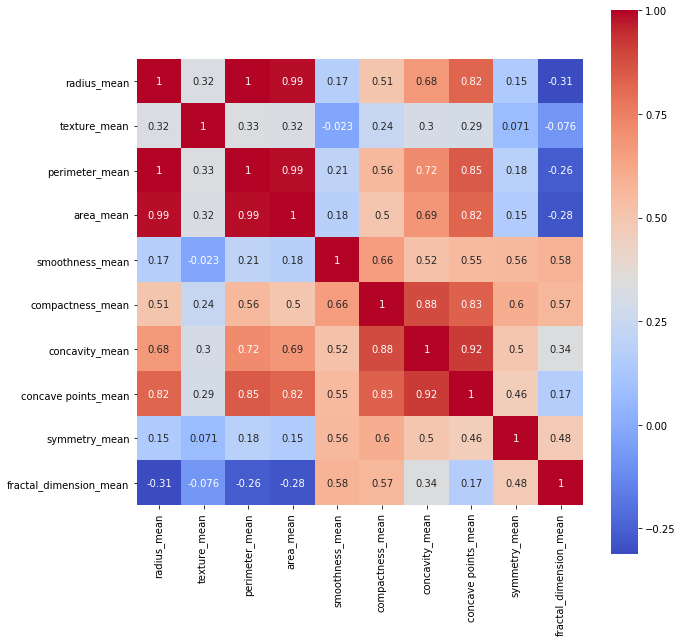

In [50]:
#fancy fonts
font = {'family' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)


# visualising the data
features_mean= list(df.columns[1:11])
plt.figure(figsize=(10,10))
sns.heatmap(df[features_mean].corr(), annot=True, square=True, cmap='coolwarm')
plt.show()

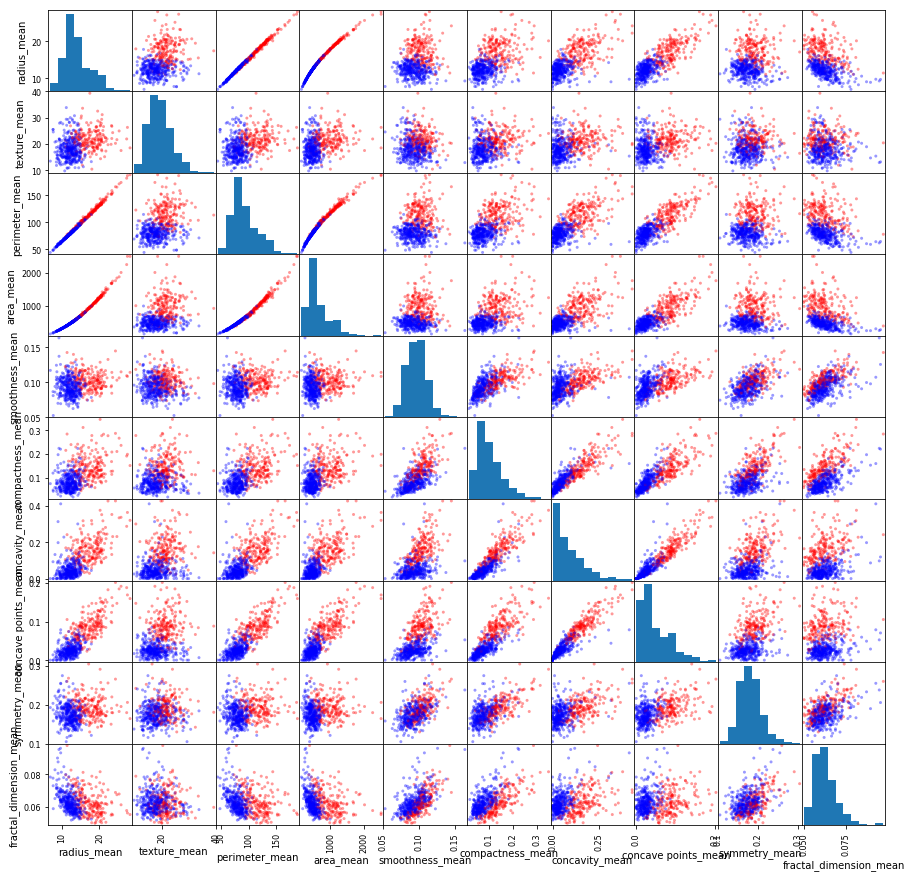

In [51]:
color_dic = {'M':'red', 'B':'blue'}
colors = df['diagnosis'].map(lambda x: color_dic.get(x))

sm = pd.scatter_matrix(df[features_mean], c=colors, alpha=0.4, figsize=((15,15)));

plt.show()

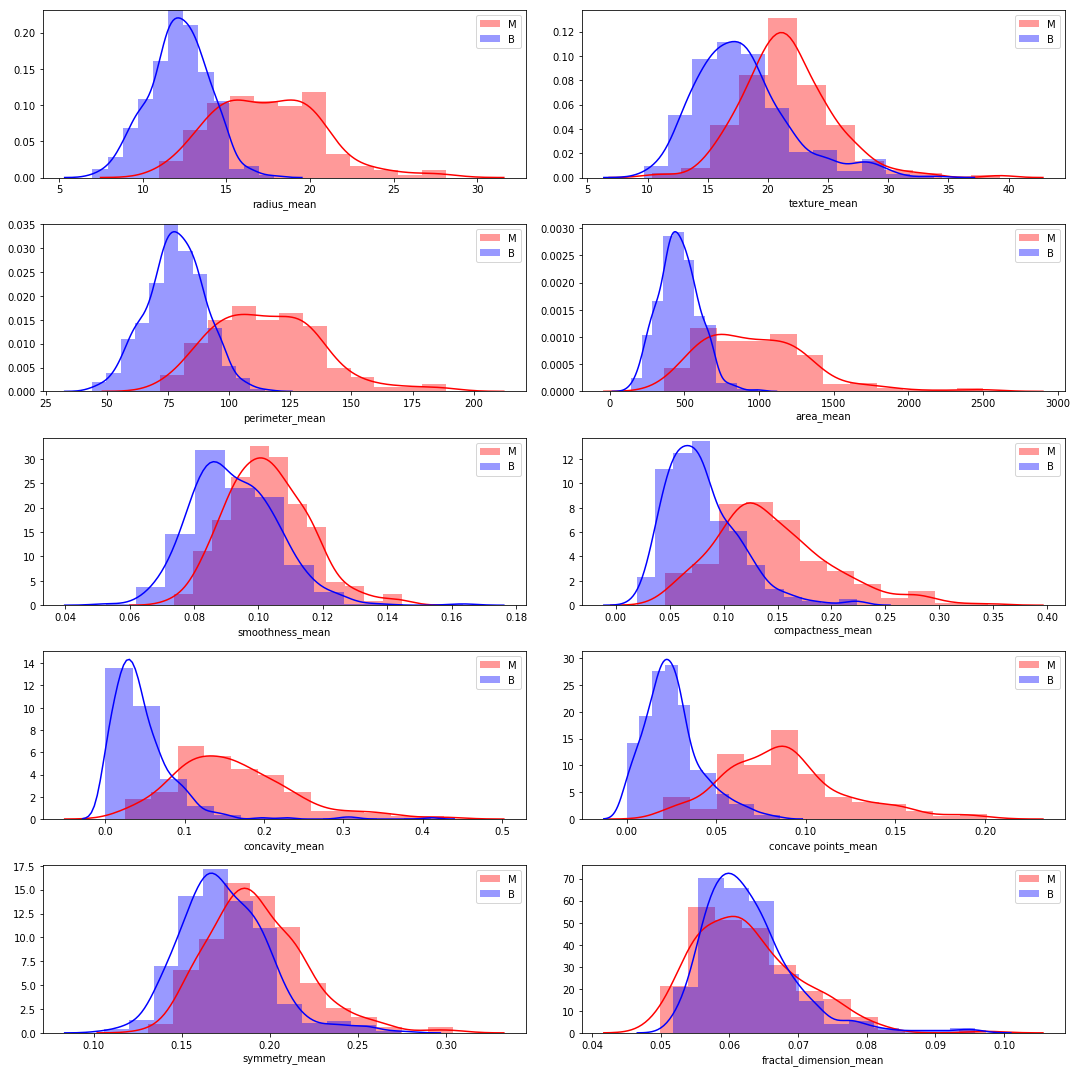

In [52]:
bins = 12
plt.figure(figsize=(15,15))
for i, feature in enumerate(features_mean):
    rows = int(len(features_mean)/2)
    
    plt.subplot(rows, 2, i+1)
    
    sns.distplot(df[df['diagnosis']=='M'][feature], bins=bins, color='red', label='M');
    sns.distplot(df[df['diagnosis']=='B'][feature], bins=bins, color='blue', label='B');
    
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

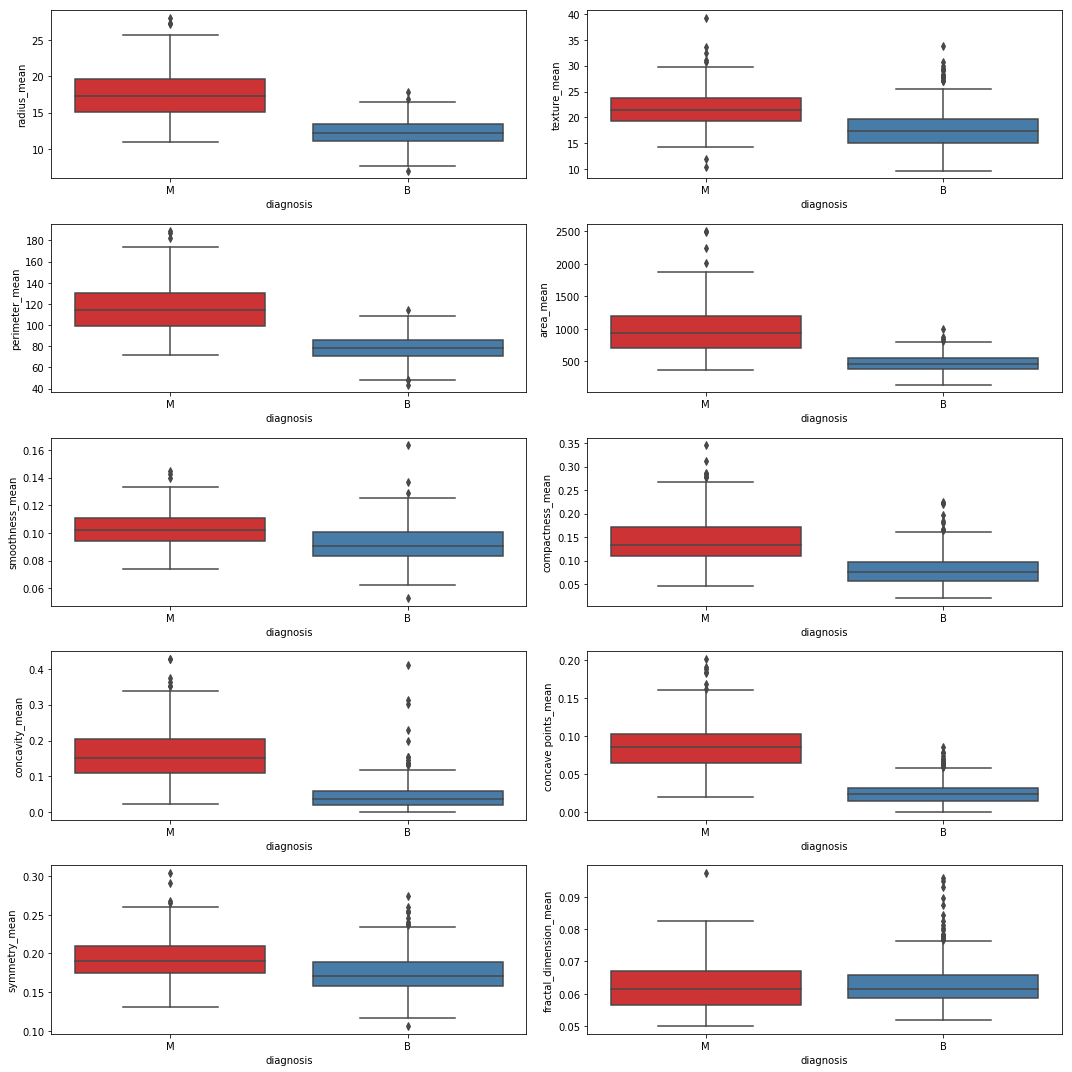

In [53]:
plt.figure(figsize=(15,15))
for i, feature in enumerate(features_mean):
    rows = int(len(features_mean)/2)
    
    plt.subplot(rows, 2, i+1)
    
    sns.boxplot(x='diagnosis', y=feature, data=df, palette="Set1")

plt.tight_layout()
plt.show()

In [54]:
# training the models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

import time

# binarasing the diagnosis
diag_map = {'M':1, 'B':0}
df['diagnosis'] = df['diagnosis'].map(diag_map)

In [55]:
X = df.loc[:,features_mean]
y = df.loc[:, 'diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

accuracy_all = []
cvs_all = []

#### Тренируем два классификатора - Байес и KNN. 

In [56]:
#The nearest neighbors classifier finds predefined number of training samples closest in distance to the new point, and predict the label from these.
from sklearn.neighbors import KNeighborsClassifier

start = time.time()

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores = cross_val_score(clf, X, y, cv=5)

end = time.time()

accuracy_all.append(accuracy_score(prediction, y_test))
cvs_all.append(np.mean(scores))

print("Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))

Accuracy: 93.86%
Cross validation score: 88.60% (+/- 6.96%)
Execution time: 0.022941 seconds 



In [57]:
#The Naive Bayes algorithm applies Bayes’ theorem with the assumption of independence between every pair of features.
from sklearn.naive_bayes import GaussianNB

start = time.time()

clf = GaussianNB()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores = cross_val_score(clf, X, y, cv=5)

end = time.time()

accuracy_all.append(accuracy_score(prediction, y_test))
cvs_all.append(np.mean(scores))

print("Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))

Accuracy: 94.74%
Cross validation score: 91.40% (+/- 5.03%)
Execution time: 0.017952 seconds 



#### KNN Accuracy: 93.86%, Bayes Accuracy: 94.74% 

Запомним точность с кроссвалидации на 50 фолдах для сравнения результатов работы двух алгоритмов. Как будто мы усовершенствовали KNN и хотим написать статью о новом методе, и доказываем, что он работает лучше.

In [58]:
start = time.time()

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores = cross_val_score(clf, X, y, cv=50)
data1=scores # записываем сюда 50 скоров кроссвалидации для KNN классификатора
pd.DataFrame(data1).to_csv('data1.csv')

end = time.time()

accuracy_all.append(accuracy_score(prediction, y_test))
cvs_all.append(np.mean(scores))

print("Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))# видим что дисперсия сильно увеличилась с количеством фолдов
print("Execution time: {0:.5} seconds \n".format(end-start))

Accuracy: 93.86%
Cross validation score: 88.87% (+/- 19.82%)
Execution time: 0.14561 seconds 



In [59]:
scores

array([0.84615385, 0.69230769, 1.        , 0.84615385, 1.        ,
       0.92307692, 0.76923077, 0.66666667, 0.83333333, 0.66666667,
       0.91666667, 1.        , 1.        , 0.72727273, 0.90909091,
       0.81818182, 0.90909091, 0.72727273, 1.        , 0.81818182,
       1.        , 0.72727273, 0.90909091, 0.90909091, 1.        ,
       0.81818182, 0.90909091, 0.90909091, 0.81818182, 0.90909091,
       1.        , 1.        , 0.90909091, 0.90909091, 1.        ,
       1.        , 1.        , 1.        , 0.90909091, 0.81818182,
       1.        , 0.72727273, 0.81818182, 0.90909091, 1.        ,
       0.90909091, 0.90909091, 0.81818182, 0.90909091, 0.90909091])

In [60]:
start = time.time()

clf = GaussianNB()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores = cross_val_score(clf, X, y, cv=5)
data2=scores # записываем сюда 50 скоров кроссвалидации для Naive Bayes классификатора
pd.DataFrame(data2).to_csv('data2.csv')

end = time.time()

accuracy_all.append(accuracy_score(prediction, y_test))
cvs_all.append(np.mean(scores))

print("Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))

Accuracy: 94.74%
Cross validation score: 91.40% (+/- 5.03%)
Execution time: 0.022938 seconds 



# 2. Оценка ошибки второго рода оценки $H_0$

![](./stat_errors.png)

В статистике различаются два вида ошибок: 
  * ошибка первого рода -- когда мы отвергаем гипотезу, а она верна;
  * ошибка второго рода -- когда мы __не__ отвергаем гипотезу, а она не верна.
  
 

In [61]:
from bootstrapped import *

Импортируем функции для подсчёта бутстрапных статистик:

  * `def bootstrap` отвечает за подсчёт интервалов с помощью бутстрапа;
  * `bootstrap_ab` производит A/B-тестирование на двух сэмплах с помощью бутстрапа;
  * `bootstrap_test` - обёртка над `bootstrap_ab`, которая дополнительно сообщает прошли ли данные тест со значимостью на уровне $\alpha$.

![Тест Уелча](http://www.statistics4u.com/fundstat_eng/img/hl_explain_welch_test.png)

$$t = \frac{x_{diff}}{\sqrt{\frac{s_1^2}{N_1} + \frac{s_2^2}{N_2}}}$$

$$v \approx \frac{\left(\frac{s_1^2}{N_1} + \frac{s_2^2}{N_2}\right)^2}{\frac{s_1^4}{N_1^2 (N_1 - 1)} + \frac{s_2^4}{N_2^2 (N_2 - 1)}}$$

#### Реализация теста Уелча
https://github.com/flowersteam/rl-difference-testing/blob/master/test_RL_difference.py

In [62]:
from tests import bootstrap, bootstrap_ab, bootstrap_test

  * `welch_test` - реализация теста Уельча с помощью `stats.ttest_ind`;
  * `compute_beta` - функция для подсчёта вероятности ошибки II рода.
  * `empirical_false_pos_rate` - функция для ??

In [63]:
stats.ttest_ind?

In [64]:
from tests import compute_beta, welch_test, empirical_false_pos_rate, plot_beta

In [65]:
# An example of AB-test with bootstrap
"""
    Imagine we own a website and think changing the color of a 'subscribe' button will improve signups. 
    One method to measure the improvement is to conduct an A/B test where we show 50% of people the old version and 50%
    of the people the new version. We can use the bootstrap to understand how much the button color improves responses 
    and give us the error bars associated with the test - this will give us lower and upper bounds on how good we should 
    expect the change to be!
"""

import numpy as np

mean = 100
stdev = 10

population = np.random.normal(loc=mean, scale=stdev, size=50000)
# take 1k 'samples' from the larger population
samples = population[:1000]

print(bootstrap(samples, stat_func=mean_))
print(bootstrap(samples, stat_func=std))

100.07945483791119    (99.43969197811786, 100.70517032421063)
10.275397066219229    (9.852731706877647, 10.713870397178475)


In [66]:
# 1. just random sample. test for N random seeds will fail
data1=np.random.random_sample(50)
data2=np.random.random_sample(50)

In [67]:
# Significance level to be used by both tests
alpha = 0.05
# Requirement in type-II error
beta_requirement = 0.2

# define the range of sample size to compute and plot beta
sample_size = range(2, 50, 2)

# define the effect size epsilon. Here we define epsilon proportionally to smaller average performance
if data1.mean() < data2.mean():
    m_smaller = data1.mean()
else:
    m_smaller = data2.mean()
epsilon = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) * m_smaller
epsilon = epsilon.tolist()

In [68]:
welch_test(data1, data2, alpha, tail=2)
bootstrap_test(data1, data2, alpha)
plt.show()



Results of the Welch's t-test level 0.05: there is not enough evidence to prove any order relation between μ1 and μ2.
Welch's t-test done.


Results of the bootstrap test level 0.05: there is not enough evidence to prove any order relation between μ1 and μ2.
Bootstrap test done.


In [69]:
# 2. random sample with delta
data1=np.random.random_sample(100)
data2=np.random.random_sample(100)-0.2



Result of the Welch's t-test level 0.05: μ1>μ2, the test passed with p-value = 7.13496e-08.
Welch's t-test done.


Result of the bootstrap test level 0.05: μ1>μ2, the test passed with a confidence interval μ1-μ2 in 0.15254, 0.316335.
Bootstrap test done.


Computing empirical false positive rate ..
     N = 2
     N = 4
     N = 6
     N = 8
     N = 10
     N = 12
     N = 14
     N = 16
     N = 18
     N = 20
     N = 22
     N = 24
     N = 26
     N = 28
     N = 30
     N = 32
     N = 34
     N = 36
     N = 38
     N = 40
     N = 42
     N = 44
     N = 46
     N = 48

   Given N=50 and α=0.05, you can expect false positive rates: 
     For the Welch's t-test: 0.052 
     For the bootstrap test: 0.062.
Done.


Computing the false negative rate as a function of sample size, for various effect sizes ..

Sample sizes satisfying β=0.2 are:
     ε = 0.048496979289435874  -->  N: >48 
     ε = 0.09699395857887175  -->  N: >48 
     ε = 0.1454909378683076  -->  N: >48 
     ε = 0.1

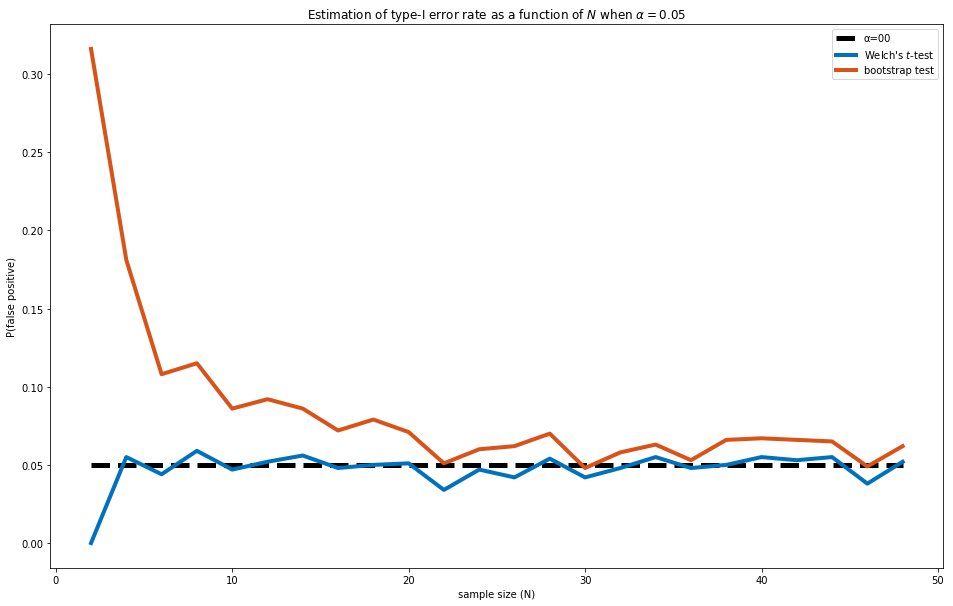

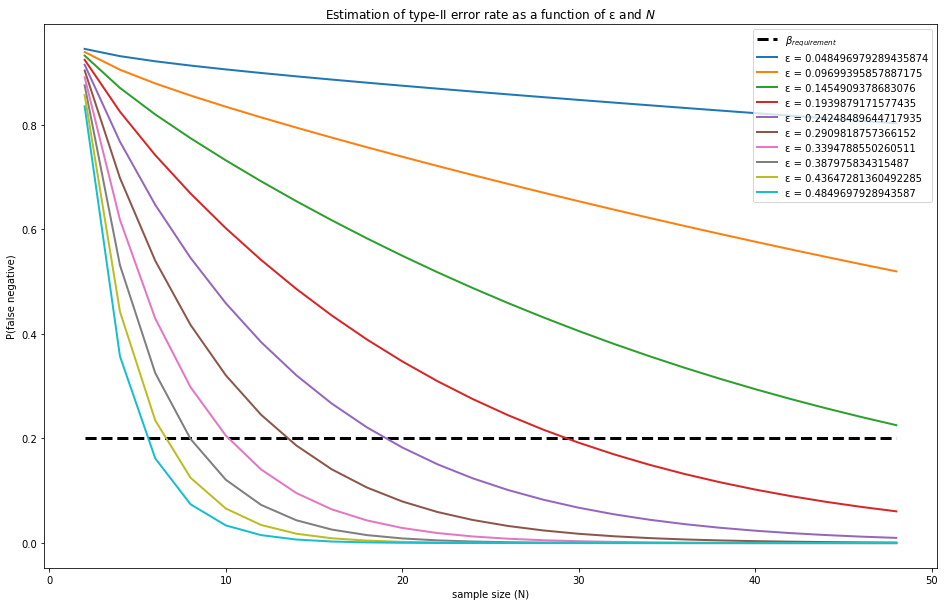

In [70]:
welch_test(data1, data2, alpha, tail=2)
bootstrap_test(data1, data2, alpha)
empirical_false_pos_rate(data1, alpha)
beta = compute_beta(epsilon, sample_size, alpha, data1, data2, beta_requirement=beta_requirement)
plot_beta(beta, epsilon, sample_size, beta_requirement=beta_requirement)
plt.show()

In [71]:
# 3. load generated data from models
path_to_data1 = 'data1.csv'
path_to_data2 = 'data2.csv'
data1 = np.asarray(pd.read_csv(path_to_data1)['0'])
data2 = np.asarray(pd.read_csv(path_to_data2)['0'])

In [72]:
data1

array([0.84615385, 0.69230769, 1.        , 0.84615385, 1.        ,
       0.92307692, 0.76923077, 0.66666667, 0.83333333, 0.66666667,
       0.91666667, 1.        , 1.        , 0.72727273, 0.90909091,
       0.81818182, 0.90909091, 0.72727273, 1.        , 0.81818182,
       1.        , 0.72727273, 0.90909091, 0.90909091, 1.        ,
       0.81818182, 0.90909091, 0.90909091, 0.81818182, 0.90909091,
       1.        , 1.        , 0.90909091, 0.90909091, 1.        ,
       1.        , 1.        , 1.        , 0.90909091, 0.81818182,
       1.        , 0.72727273, 0.81818182, 0.90909091, 1.        ,
       0.90909091, 0.90909091, 0.81818182, 0.90909091, 0.90909091])



Results of the Welch's t-test level 0.05: there is not enough evidence to prove any order relation between μ1 and μ2.
Welch's t-test done.


Results of the bootstrap test level 0.05: there is not enough evidence to prove any order relation between μ1 and μ2.
Bootstrap test done.


Computing empirical false positive rate ..
     N = 2
     N = 4
     N = 6
     N = 8
     N = 10
     N = 12
     N = 14
     N = 16
     N = 18
     N = 20
     N = 22
     N = 24

   Given N=25 and α=0.05, you can expect false positive rates: 
     For the Welch's t-test: 0.05 
     For the bootstrap test: 0.068.
Done.


Computing the false negative rate as a function of sample size, for various effect sizes ..

Sample sizes satisfying β=0.2 are:
     ε = 0.048496979289435874  -->  N: 30 
     ε = 0.09699395857887175  -->  N: 10 
     ε = 0.1454909378683076  -->  N: 6 
     ε = 0.1939879171577435  -->  N: 4 
     ε = 0.24248489644717935  -->  N: 4 
     ε = 0.2909818757366152  -->  N: 4 
     ε = 0.3394

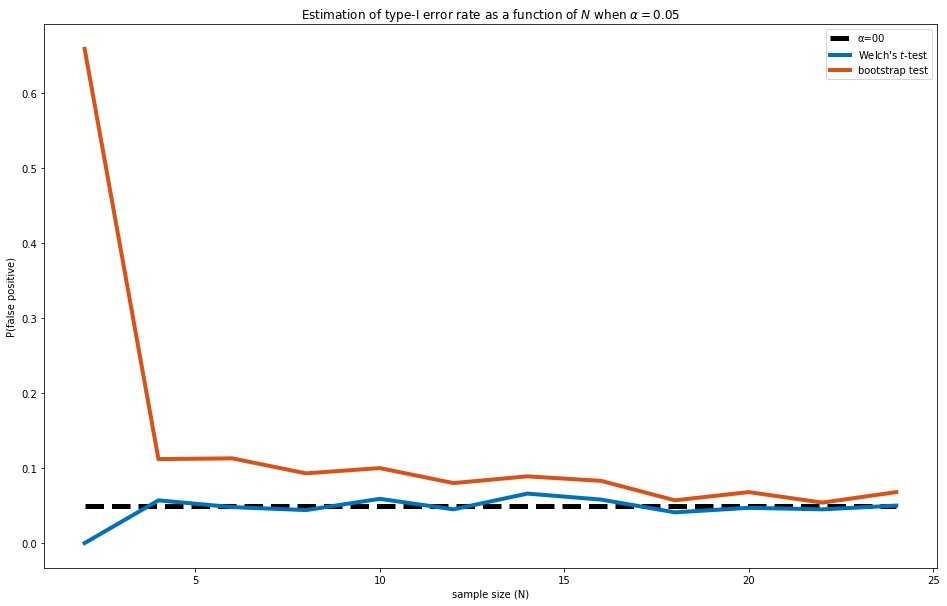

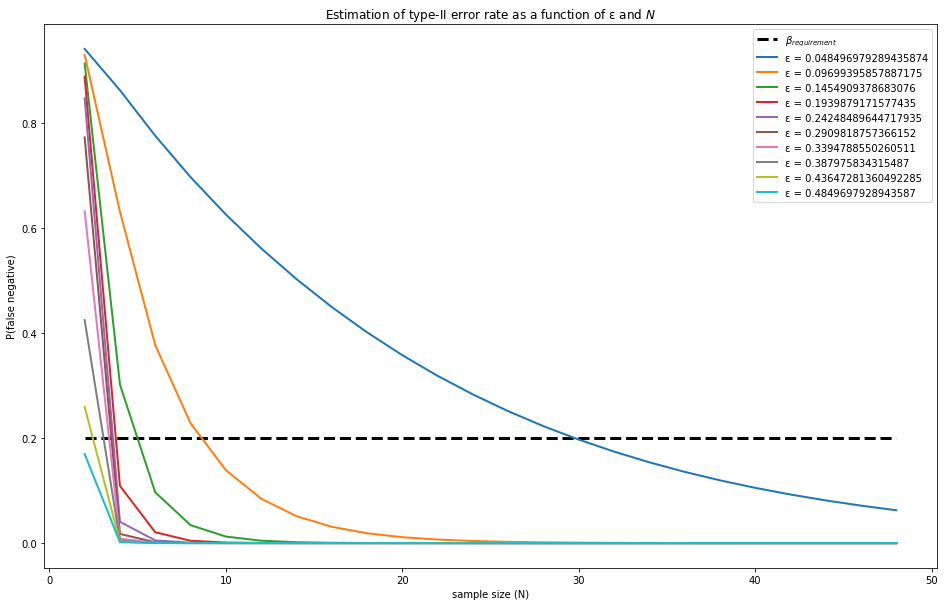

In [73]:
welch_test(data1, data2, alpha, tail=2)
bootstrap_test(data1, data2, alpha)
empirical_false_pos_rate(data1, alpha)
beta = compute_beta(epsilon, sample_size, alpha, data1, data2, beta_requirement=beta_requirement)
plot_beta(beta, epsilon, sample_size, beta_requirement=beta_requirement)
plt.show()

### Увеличим количество фолдов до 100

In [74]:
start = time.time()

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores = cross_val_score(clf, X, y, cv=100)
data1=scores # записываем сюда 100 скоров кроссвалидации для KNN классификатора
pd.DataFrame(data1).to_csv('data1.csv')

end = time.time()

accuracy_all.append(accuracy_score(prediction, y_test))
cvs_all.append(np.mean(scores))

print("Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))# видим что дисперсия сильно увеличилась с количеством фолдов
print("Execution time: {0:.5} seconds \n".format(end-start))

Accuracy: 93.86%
Cross validation score: 89.02% (+/- 29.13%)
Execution time: 0.26928 seconds 



In [75]:
#The Naive Bayes algorithm applies Bayes’ theorem with the assumption of independence between every pair of features.
from sklearn.naive_bayes import GaussianNB

start = time.time()

clf = GaussianNB()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores = cross_val_score(clf, X, y, cv=100)
data2 =scores # записываем сюда 100 скоров кроссвалидации
pd.DataFrame(data2).to_csv('data2.csv')
end = time.time()

accuracy_all.append(accuracy_score(prediction, y_test))
cvs_all.append(np.mean(scores))

print("Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))

Accuracy: 94.74%
Cross validation score: 91.36% (+/- 25.28%)
Execution time: 0.22044 seconds 



In [77]:
# И потом ещё стохастический градиент можно поробовать до кучи
from sklearn.linear_model import SGDClassifier

start = time.time()

clf = SGDClassifier(random_state=42)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores = cross_val_score(clf, X, y, cv=100)
data2=scores # записываем сюда 100 скоров кроссвалидации для Стохастического градиента
pd.DataFrame(data2).to_csv('data2.csv')
end = time.time()

accuracy_all.append(accuracy_score(prediction, y_test))
cvs_all.append(np.mean(scores))

print("SGD Classifier Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: %s seconds \n" % "{0:.5}".format(end-start))

SGD Classifier Accuracy: 91.23%
Cross validation score: 71.61% (+/- 41.59%)
Execution time: 0.3012 seconds 





Result of the Welch's t-test level 0.05: μ1>μ2, the test passed with p-value = 1.37589e-10.
Welch's t-test done.


Result of the bootstrap test level 0.05: μ1>μ2, the test passed with a confidence interval μ1-μ2 in 0.119657, 0.222723.
Bootstrap test done.


Computing empirical false positive rate ..
     N = 2
     N = 4
     N = 6
     N = 8
     N = 10
     N = 12
     N = 14
     N = 16
     N = 18
     N = 20
     N = 22
     N = 24
     N = 26
     N = 28
     N = 30
     N = 32
     N = 34
     N = 36
     N = 38
     N = 40
     N = 42
     N = 44
     N = 46
     N = 48

   Given N=50 and α=0.05, you can expect false positive rates: 
     For the Welch's t-test: 0.048 
     For the bootstrap test: 0.057.
Done.


Computing the false negative rate as a function of sample size, for various effect sizes ..

Sample sizes satisfying β=0.2 are:
     ε = 0.048496979289435874  -->  N: >48 
     ε = 0.09699395857887175  -->  N: 44 
     ε = 0.1454909378683076  -->  N: 20 
     ε = 0.19

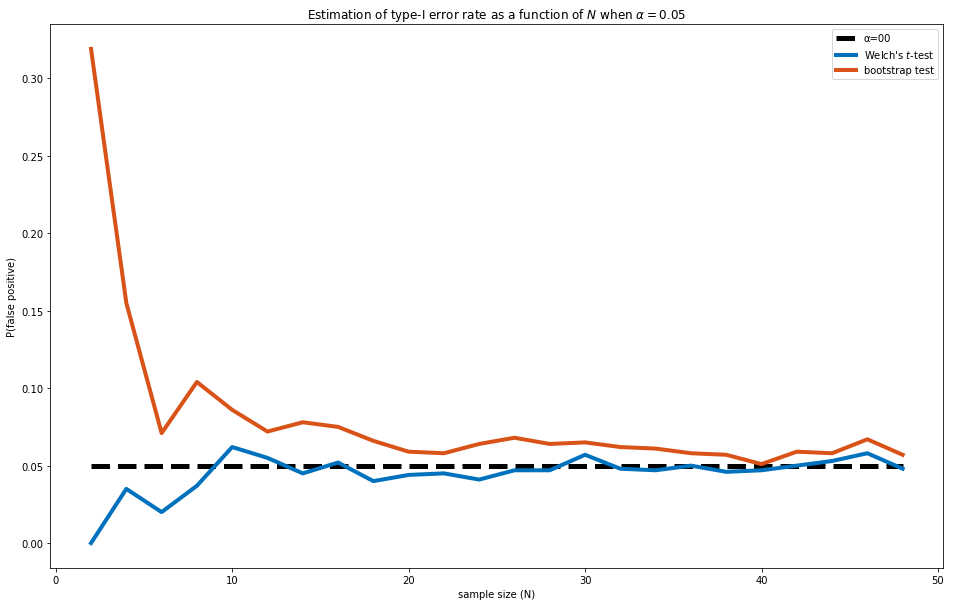

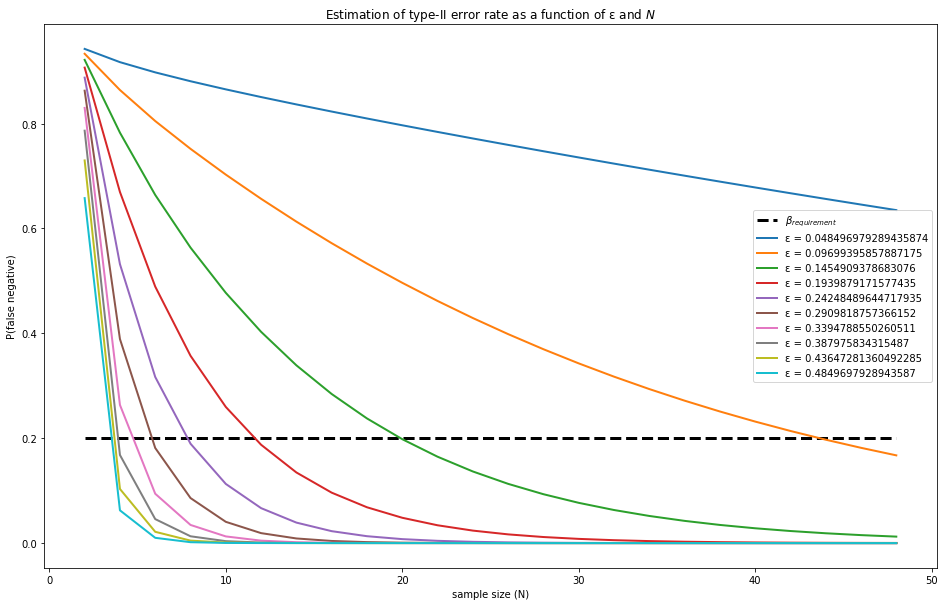

In [78]:
path_to_data1 = 'data1.csv'
path_to_data2 = 'data2.csv'
data1 = np.asarray(pd.read_csv(path_to_data1)['0'])
data2 = np.asarray(pd.read_csv(path_to_data2)['0'])
welch_test(data1, data2, alpha, tail=2)
bootstrap_test(data1, data2, alpha)
empirical_false_pos_rate(data1, alpha)
beta = compute_beta(epsilon, sample_size, alpha, data1, data2, beta_requirement=beta_requirement)
plot_beta(beta, epsilon, sample_size, beta_requirement=beta_requirement)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

start = time.time()

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
scores = cross_val_score(clf, X, y, cv=100)

end = time.time()

accuracy_all.append(accuracy_score(prediction, y_test))
cvs_all.append(np.mean(scores))

print("Random Forest Accuracy: {0:.2%}".format(accuracy_score(prediction, y_test)))
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))
print("Execution time: {0:.5} seconds \n".format(end-start))